In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:98% !important; }</style>"))
# display("text/html", "<style>.container { width:100% !important; }</style>")

In [2]:
import os
%cd /home/mila/l/limjaehy/projs/func-sdeflow-dev-jmlr

/home/mila/l/limjaehy/projs/func-sdeflow-dev-jmlr


In [3]:
import importlib, sys
import functools
import math

import numpy as np

import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

MYBACKEND = plt.get_backend()
print(MYBACKEND)

%matplotlib inline

module://matplotlib_inline.backend_inline


In [4]:
from utils.visualize import *
matplotlib.use(MYBACKEND)

In [5]:
from main import *

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters_million(model):
    return int( count_parameters(model) / 1e6 )

use gpu



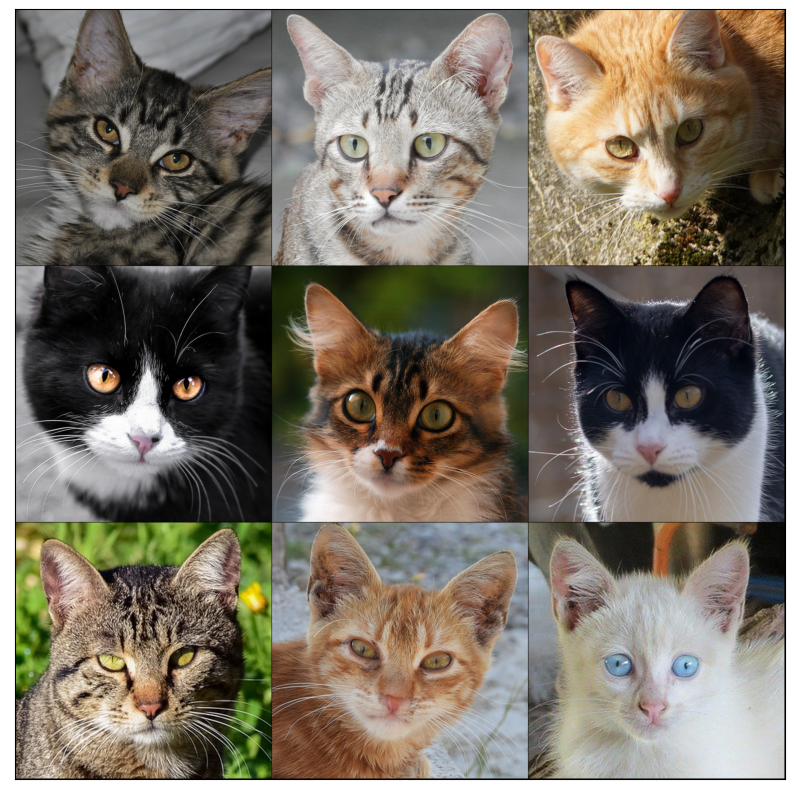

In [7]:
import os
import argparse

from utils import datasets
# from utils.visualize import plot_scatter, plot_contourf

nrow = 3
batch_size = nrow**2

# init device
if torch.cuda.is_available():
    device = 'cuda'
    print('use gpu\n')
else:
    device = 'cpu'
    print('use cpu\n')

# init dataset
train_loader, _, _ = datasets.get_loaders_eval(
    dataset='afhqv2_cat_1024', #'ffhq_1024',
    root='/home/mila/l/limjaehy/scratch/data', #'/network/datasets/ffhq',
    distributed=False,
    batch_size=batch_size,
    centered=False,
    num_workers=1,
    shuffle_train=False,
)

# fetch
train_iter = iter(train_loader)
x, _ = next(train_iter)
x, _ = next(train_iter)
x = x * 255 / 256 + torch.rand_like(x) / 256 # dequantize
x = x.to(device)

plt.figure(figsize=(10,10))
plt.imshow(
    get_grid_image(x[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=2, normalize=False, to_numpy=True)
)
plt.xticks([])
plt.yticks([])
plt.show()


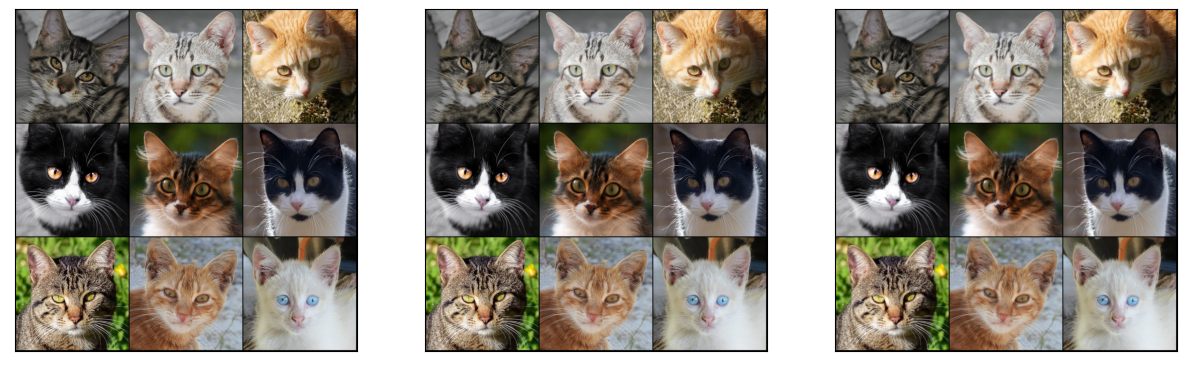

In [8]:
from lib.models.aliasfree_dct import Upsample2d, Downsample2d
down2 = Downsample2d(
    scale_factor=0.5,
    filter_size=9,
    use_radial=False,
).to(device)
down4 = Downsample2d(
    scale_factor=0.25,
    filter_size=9,
    use_radial=False,
).to(device)

# from lib.models.upsample import Upsample2d, Downsample2d
# down2 = Downsample2d(2).to(device)
# down4 = Downsample2d(4).to(device)

x1 = x
x2 = down2(x1).clip(0,1)
x4 = down4(x1).clip(0,1)


plt.close('all')
fig, axes = plt.subplots(1, 3, figsize=(15,10))

axes[0].imshow(
    get_grid_image(x1[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=8, normalize=False, to_numpy=True)
)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(
    get_grid_image(x2[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=4, normalize=False, to_numpy=True)
)
axes[1].set_xticks([])
axes[1].set_yticks([])


axes[2].imshow(
    get_grid_image(x4[:nrow**2].cpu(), nrow=nrow, pad_value=0, padding=2, normalize=False, to_numpy=True)
)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.show()

In [9]:
height1 = x1.shape[-1]
height2 = x2.shape[-1]
height4 = x4.shape[-1]
print(height1, height2, height4)

1024 512 256


In [10]:
import time
import argparse


# init
cuda = True
args = argparse.Namespace()


# dataset
args.in_channels = 2
args.out_channels = 3
x_train = x4
args.train_img_height = x_train.shape[-1]
args.base_resolution = args.train_img_height // 2
args.forward = forward = to_center
args.reverse = reverse = to_01_clip

# train
args.batch_size = 1
args.lr = 1e-4 #0.001
args.lr_min = 1e-5 #1e-4
args.max_norm = 1.0
args.num_iters = 5000
args.warmup_iters = 1000
args.print_every = 100


# get model
args.modes = 64
args.ch = 32 #64
args.separable = True
from lib.models.fno import FNO2d
model = FNO2d(
    modes1=args.modes if hasattr(args, 'modes') else None,
    modes2=args.modes//2 if hasattr(args, 'modes') else None,
    width=args.ch,
    in_ch=args.in_channels,
    out_ch=args.out_channels,
    separable=args.separable if hasattr(args, 'separable') else False,
)
print(model)
print( f'# params: {count_parameters_million(model)}M' )
print()

if cuda:
    model = model.cuda()

# optimizer
optim = torch.optim.Adam(model.parameters(), lr=args.lr)

# lr scheduler
if args.warmup_iters > 0:
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optim,
        T_max=float(args.num_iters - args.warmup_iters - 1),
        eta_min=args.lr_min,
    )
else:
    lr_scheduler = None

# training
ind = 1 #5
y = args.forward(x_train[ind:ind+args.batch_size])
v = get_mgrid(args.in_channels, args.train_img_height).repeat(args.batch_size, 1, 1, 1)
if cuda:
    v = v.cuda()
    y = y.cuda()
model.train()
start_time = time.time()
for count in range(args.num_iters):
    if lr_scheduler is not None and count+1 > args.warmup_iters:
        lr_scheduler.step()
    optim.zero_grad()

    pred = model(v)

    loss = ((y - pred)**2).mean()

    # backward
    loss.backward()

    # gradient clipping
    if args.max_norm > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.max_norm)

    # update
    optim.step()

    # print
    if (count == 0) or (count+1) % args.print_every == 0:
        elapsed = (time.time() - start_time) / args.print_every * 1000
        start_time = time.time()
        _lr = lr_scheduler.get_last_lr()[-1] if lr_scheduler is not None else args.lr
        print('iter: {:5d} | time: {:7.2f} ms | loss: {:7.2f} | lr {:7.5f}'.format(count+1, elapsed, loss.item() * 1000, _lr))



FNO2d(
  (conv0): SpectralConv2d(separable=True)
  (conv1): SpectralConv2d(separable=True)
  (conv2): SpectralConv2d(separable=True)
  (conv3): SpectralConv2d(separable=True)
  (conv4): SpectralConv2d(separable=True)
  (conv6): SpectralConv2d(separable=True)
  (conv5): SpectralConv2d(separable=True)
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (w4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (w5): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (w6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (fc0): Linear(in_features=5, out_features=32, bias=True)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
# params: 1M


FNO2d
diff 1:   2.811
diff 2:   2.175
diff 4:   0.563


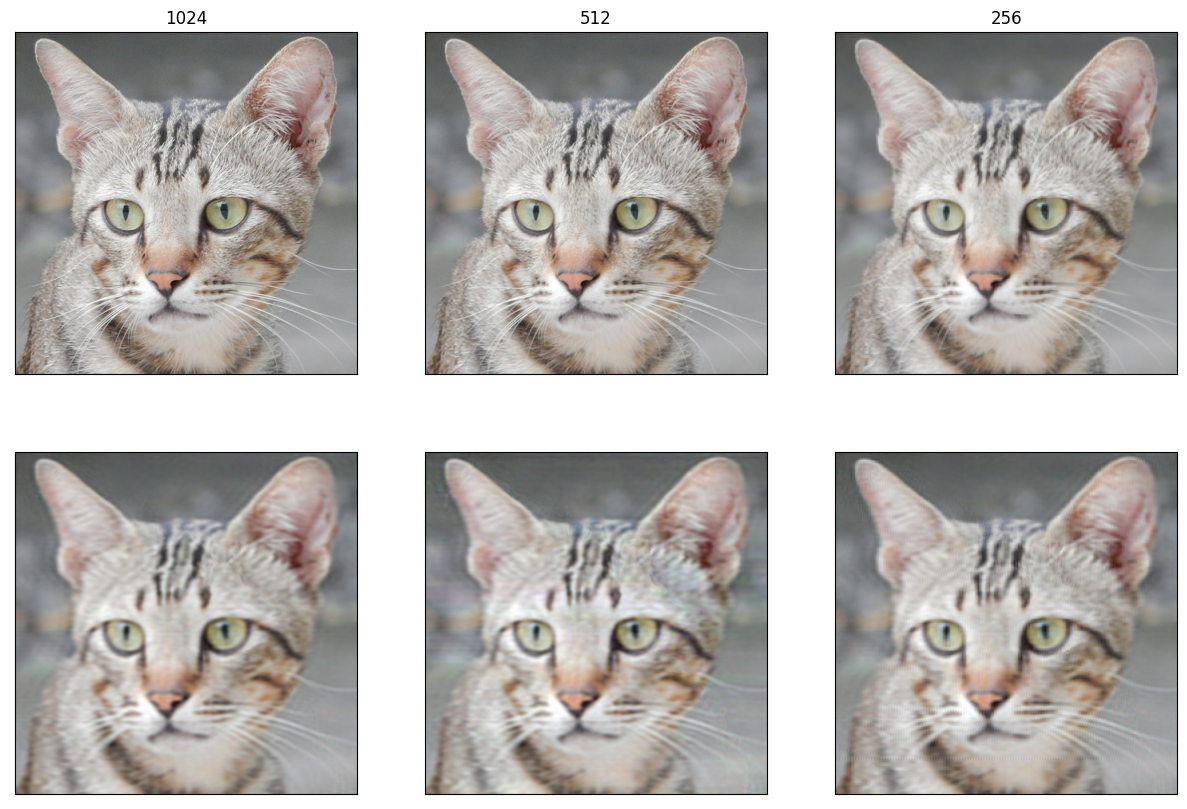

In [11]:
print(model.__class__.__name__)

v1 = get_mgrid(args.in_channels, height1).repeat(args.batch_size, 1, 1, 1)
v2 = get_mgrid(args.in_channels, height2).repeat(args.batch_size, 1, 1, 1)
v4 = get_mgrid(args.in_channels, height4).repeat(args.batch_size, 1, 1, 1) # training resolution

if cuda:
    v1 = v1.cuda()
    v2 = v2.cuda()
    v4 = v4.cuda()

with torch.no_grad():
    model.eval()
    pred4 = model(v4).detach().clone()
    pred2 = model(v2).detach().clone()
    pred1 = model(v1).detach().clone()

diff1 = ((x1[ind:ind+1] - args.reverse(pred1))**2).mean().item() * 1000
print('diff 1: {:7.3f}'.format(diff1))
diff2 = ((x2[ind:ind+1] - args.reverse(pred2))**2).mean().item() * 1000
print('diff 2: {:7.3f}'.format(diff2))
diff4 = ((x4[ind:ind+1] - args.reverse(pred4))**2).mean().item() * 1000
print('diff 4: {:7.3f}'.format(diff4))

plt.close('all')
fig, axes = plt.subplots(2, 3, figsize=(15,10))

axes[0,0].imshow(
    get_grid_image(x1[ind:ind+1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[0,0].set_title(f'{height1}')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,1].imshow(
    get_grid_image(x2[ind:ind+1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[0,1].set_title(f'{height2}')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[0,2].imshow(
    get_grid_image(x4[ind:ind+1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[0,2].set_title(f'{height4}')
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])

axes[1,0].imshow(
    get_grid_image(args.reverse(pred1)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])
axes[1,1].imshow(
    get_grid_image(args.reverse(pred2)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,2].imshow(
    get_grid_image(args.reverse(pred4)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True),
)
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])
plt.show()

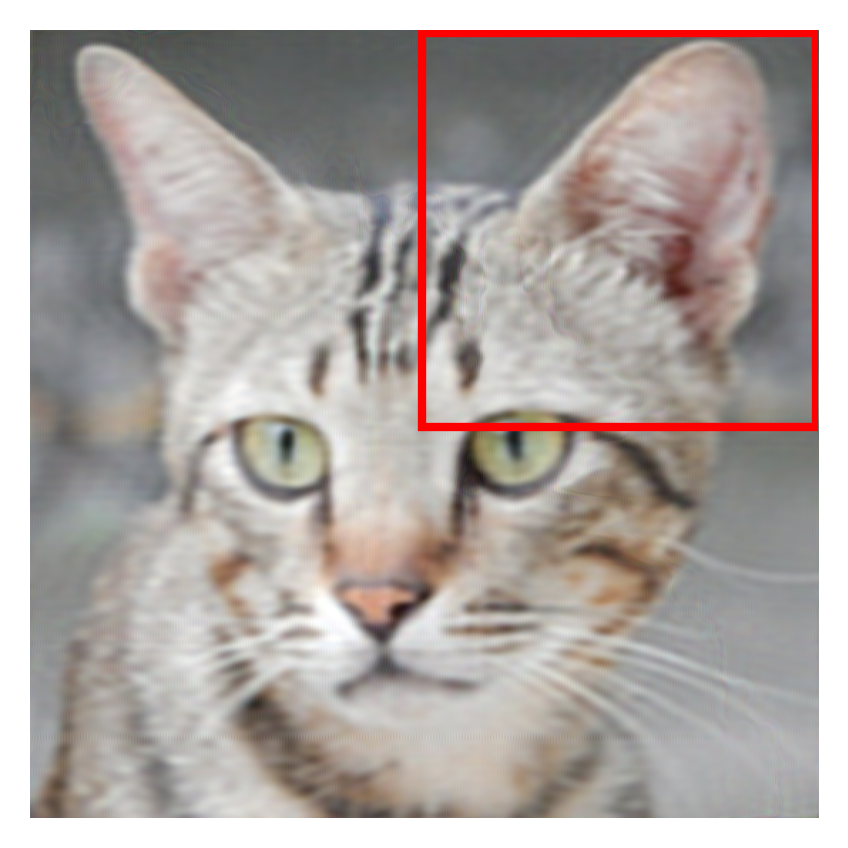

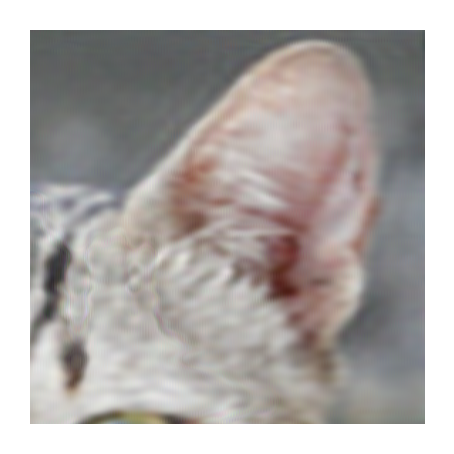

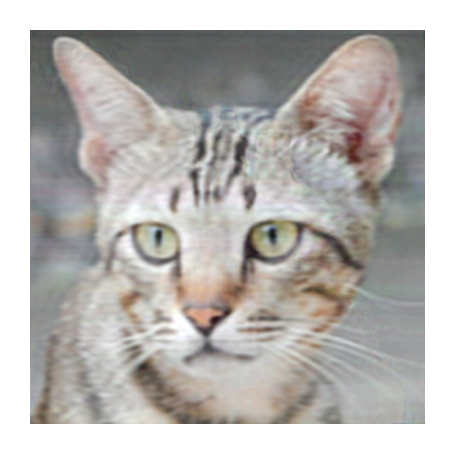

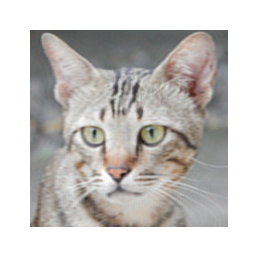

In [12]:
from matplotlib.patches import Rectangle

def save_image(image, model_name, my_dpi=300, add_rect=False):
    height = image.shape[0]
    width = image.shape[1]
    plt.figure(figsize=(height/my_dpi, width/my_dpi), dpi=my_dpi)
    plt.imshow(image)
    ax = plt.gca()
    ax.axis(False)
    if add_rect:
        half_height = height//2
        half_width = width//2
        # rect = Rectangle((half_height-4,half_width-4),half_height,half_width,linewidth=2,edgecolor='r',facecolor='none')
        rect = Rectangle((half_height-4,4),half_height,half_width,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        # patch = image[half_height:,half_width:]
        patch = image[:half_height,half_width:]
    plt.savefig(f'samples/fitting_{model_name}_{height}x{width}.pdf', dpi=my_dpi, bbox_inches='tight', transparent=True, pad_inches=0.0)
    plt.show()
    if add_rect:
        plt.figure(figsize=(half_height/my_dpi, half_width/my_dpi), dpi=my_dpi)
        plt.imshow(patch)
        ax = plt.gca()
        ax.axis(False)
        plt.savefig(f'samples/fitting_{model_name}_{height}x{width}_patch.pdf', dpi=my_dpi, bbox_inches='tight', transparent=True, pad_inches=0.0)
        plt.show()
    return None

save_image(get_grid_image(args.reverse(pred1)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True), model_name='fno', my_dpi=300, add_rect=True)
save_image(get_grid_image(args.reverse(pred2)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True), model_name='fno', my_dpi=300)
save_image(get_grid_image(args.reverse(pred4)[:1].cpu(), nrow=1, pad_value=0, padding=0, normalize=False, to_numpy=True), model_name='fno', my_dpi=300)

plt.close('all')